In [ ]:

# install
!pip install causalinference==0.1.2
!pip install pymatch
!pip install statsmodels==0.14.0
!pip install networkx matplotlib
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from causalinference import CausalModel
from pymatch.Matcher import Matcher

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for causalinference: filename=CausalInference-0.1.2-py3-none-any.whl size=51107 sha256=4f446cc3691f0eb041cdb6d067daea3d0ac89c716f535eef08544cbcaab01aec
  Stored in directory: /root/.cache/pip/wheels/76/a7/66/aec0079120fe599189f994314580c95fa54a485fdff493c124
Successfully built causalinference

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Preparing metadata (setup.py) ... done
  Created wheel for pymatch: filename=pymatch-0.3.4-py3-none-any.whl size=9116 sha256=ac0a0586d685bd9562e4710ddf2c062396889f8b8185b4beace5441efe908a6f
  Stored in directory: /root/.cache/pip/wheels/f2/10/99/d835e60df49ea4e8dffe9b92225760e449e887d54e8d109b5e
Successfully built pymatch

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━

# Overview of Datasets

## 2018 Democratic Primary Datasets
    The dems_candidates.csv dataset contains several columns with both quantitative and categorical data about candidates who participated in the 2018 Democratic primaries for Senate, House, and governor. Here's a brief introduction to the columns:

#### Quantitative Variables:
- **Partisan Lean:** the average difference between how a state or district voted in the past two presidential elections and how the country voted overall, with 2016 results weighted 75 percent and 2012 results weighted 25 percent.
- **Primary %:**  This is the percentage of votes each candidate received in their primary election. A higher percentage indicates a greater share of the vote.
#### Categorical Variables:
- **Candidate:** The name of the candidate.
- **State:** The state in which the candidate ran. This variable could show geographic trends in election outcomes.
- **District:** The specific district or office area for which the candidate ran.
- **Office Type:** The type of office the candidate sought, such as Senate, House, or governor.
- **Race Type:** Indicates whether the election was a regular election or a special election.
- **Race Primary Election Date:** The date on which the primary election was held.
- **Primary Status:** Shows whether the candidate lost the primary or advanced to a runoff.
- **Primary Runoff Status:** Indicates the candidate's status in any runoff elections.
- **General Status:** Shows whether the candidate has advanced to the general election.
- **Won Primary:** Shows whether or not the candidate won the primary
- **Race:** "White" if the candidate is non-Hispanic and "Nonwhite" otherwise
- **Veteran?:** Whether or not the candidate was a veteran
- **LGBTQ?:** Whether or not the candidate identified as part of the LGBTQ community
- **Elected Official?:** Whether or not the candidate had held elected office before
- **Self-Funder?:** “Yes” if the candidate donated or loaned a cumulative $400,000 or more to his or her own campaign before the primary and “No” for all other candidates.
- **STEM?:** Whether or not the candidate has a background in STEM
- **Obama Alum?:** Whether or not the candidate has worked for the Obama Administration
## 2018 Republican Primary Datasets
    The `rep_candidates.csv` dataset contains several columns with both quantitative and categorical data about candidates who participated in the 2018 Republican primaries for Senate, House, and governor. Here's a brief introduction to the columns:

#### Quantitative Variables
- **Primary %**: This is the percentage of votes each candidate received in their primary election. A higher percentage indicates a greater share of the vote.

#### Categorical Variables
- **Candidate**: The name of the candidate.
- **State**: The state in which the candidate ran. This variable could show geographic trends in election outcomes.
- **District**: The specific district or office area for which the candidate ran.
- **Office Type**: The type of office the candidate sought, such as Senate, House, or governor.
- **Race Type**: Indicates whether the election was a regular election or a special election.
- **Race Primary Election Date**: The date on which the primary election was held.
- **Primary Status**: Shows whether the candidate lost the primary or advanced to a runoff.
- **Primary Runoff Status**: Indicates the candidate's status in any runoff elections.
- **General Status**: Shows whether the candidate has advanced to the general election.

#### Endorsement-Related Variables
For all endorsements, there are columns such as 'Trump Endorsed?', 'NRA Endorsed?', 'Right to Life Endorsed?', etc. Each of these categorical variables indicates whether a candidate received an endorsement ('Yes'), was running against an endorsed candidate or was explicitly not endorsed ('No'), or if there was no information available about an endorsement ('No Info'). These variables can be aggregated to create a new quantitative variable:

- **Number of Endorsements**: A derived count of how many endorsements each candidate received. This number could be insightful when determining the cumulative impact of endorsements on primary outcomes.

- **Won Primary**: A binary variable indicating whether the candidate won their primary. It is a key outcome variable that can be used to measure success in the primaries.

Each of these columns can provide valuable insights into the dynamics of the primaries. For instance, endorsements might correlate with a higher 'Primary %' or a greater likelihood of winning the primary ('Won Primary'). Additionally, the 'State' variable can help analyze regional differences in election outcomes and endorsement impacts.

### Dems Dataset

In [ ]:
dems = pd.read_csv('dem_candidates.csv')
dems.head(5)
dems.info()
dems.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Candidate                   811 non-null    object 
 1   State                       811 non-null    object 
 2   District                    811 non-null    object 
 3   Office Type                 811 non-null    object 
 4   Race Type                   811 non-null    object 
 5   Race Primary Election Date  811 non-null    object 
 6   Primary Status              811 non-null    object 
 7   Primary Runoff Status       811 non-null    object 
 8   General Status              789 non-null    object 
 9   Partisan Lean               811 non-null    float64
 10  Primary %                   801 non-null    float64
 11  Won Primary                 789 non-null    object 
 12  Race                        655 non-null    object 
 13  Veteran?                    800 non

,Partisan Lean,Primary %
count,811.000000,801.000000
mean,-13.546634,29.927453
std,20.865331,26.236663
min,-65.209999,0.120000
25%,-26.830000,9.170000
50%,-14.430000,22.100000
75%,-3.985000,41.500000
max,65.089996,100.000000


### Reps Dataset

In [ ]:
rep = pd.read_csv('rep_candidates.csv')
rep.head(5)
rep.info()
rep.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Candidate                   774 non-null    object 
 1   State                       774 non-null    object 
 2   District                    774 non-null    object 
 3   Office Type                 774 non-null    object 
 4   Race Type                   774 non-null    object 
 5   Race Primary Election Date  774 non-null    object 
 6   Primary Status              774 non-null    object 
 7   Primary Runoff Status       774 non-null    object 
 8   General Status              774 non-null    object 
 9   Primary %                   773 non-null    float64
 10  Won Primary                 774 non-null    object 
 11  Rep Party Support?          138 non-null    object 
 12  Trump Endorsed?             71 non-null     object 
 13  Bannon Endorsed?            43 non-

,Primary %
count,773.000000
mean,32.176067
std,32.280339
min,0.000000
25%,5.610000
50%,21.500000
75%,46.810000
max,100.000000


## Research Question 1: 
### Multiple Hypothesis Testing
    Using data from the 2018 democratic and Republican primaries, is there a significant difference between personal characteristics such as race, veteran, lgbtq, funding status and winning a primary election?

### Hypothesis We Will Be Working With
#### (Part 1) Hypotheses for Democrats:
1. Democratic candidates who self-fund their campaigns have a higher primary success rate.
2. Democratic candidates with a more favorable partisan lean have a higher primary success rate. 
3. Veteran status of Democratic candidates impacts the success in winning primaries.
4. LGBTQ status of Democratic candidates impacts the success in winning primaries.
#### (Part 2) Hypotheses for Republicans:
5. Republican candidates with higher Primary % have a higher primary success rate.
6. Republican candidates who are endorsed by Trump have a higher primary success rate.

## EDA for Question 1: Part 1

#### Visualization for Hypothesis 1

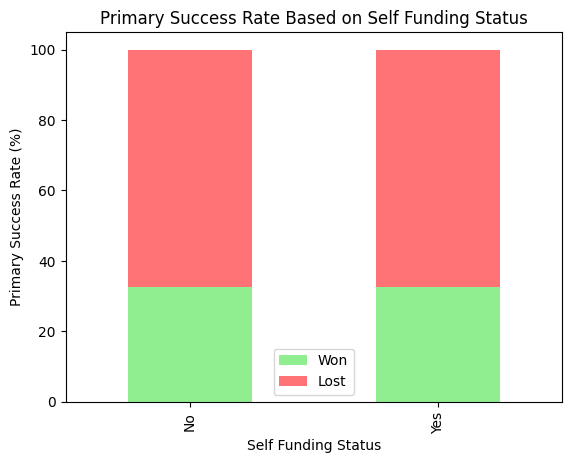

Primary Status,Advanced,Lost
Self-Funder?,,
No,251,517
Yes,14,29


In [ ]:
self_funded_success_count = dems.groupby('Self-Funder?')['Primary Status'].value_counts().unstack().fillna(0)
self_funded_success_rate = self_funded_success_count.div(self_funded_success_count.sum(axis=1), axis=0)*100

self_funded_success_rate.plot(kind = 'bar', stacked = True, color = ['#90EE90', '#FF7276'])
plt.title('Primary Success Rate Based on Self Funding Status')
plt.xlabel('Self Funding Status')
plt.ylabel('Primary Success Rate (%)')
plt.legend(['Won', 'Lost'])

plt.show()

self_funded_success_count

In [ ]:
self_funders = self_funded_success_count['Advanced']['Yes'].sum() + self_funded_success_count['Lost']['Yes'].sum()
non_self_funders = self_funded_success_count['Advanced']['No'].sum() + self_funded_success_count['Lost']['No'].sum()
print('Total Self Funded: ', self_funded_success_count['Advanced']['Yes'].sum() + self_funded_success_count['Lost']['Yes'].sum())
print('Total Not Self Funded: ', self_funded_success_count['Advanced']['No'].sum() + self_funded_success_count['Lost']['No'].sum())
print('Percentage of Success Within Self Funders:', self_funded_success_count['Advanced']['Yes'].sum() / self_funders * 100)
print('Percentage of Success Within Non Self Funders:', self_funded_success_count['Advanced']['No'].sum() / non_self_funders * 100)
print('Difference between percents:', (self_funded_success_count['Advanced']['No'].sum() / non_self_funders * 100) - (self_funded_success_count['Advanced']['Yes'].sum() / self_funders * 100))

Total Self Funded:  43
Total Not Self Funded:  768
Percentage of Success Within Self Funders: 32.55813953488372
Percentage of Success Within Non Self Funders: 32.68229166666667
Difference between percents: 0.12415213178294948


**Take Aways:** After looking deeper into the influence of being a self-funded candidate, we see that being self-funded doesn't seem to have any significant impact on whether or not the candidate will win the primary elections. There is only a 0.12 percent difference between success within self-funders and non-self-funders.

Being a Non-Self Funded candidate has an insignificant (0.12%)  impact on being successful in the 2018 primary elections. We will need to do hypothesis testing to verify if these close percentages are significant or if they are by chance.

#### Visualization for Hypothesis 2

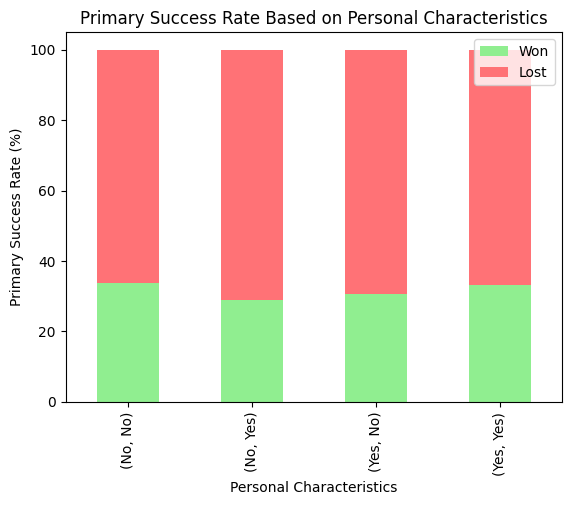

Percentage Success Rates:
            No                   Yes           
            No        Yes         No        Yes
Won   33.74613  29.032258  30.769231  33.333333
Lost  66.25387  70.967742  69.230769  66.666667


In [ ]:
counts = {
    ('No', 'No'): [218, 428],
    ('No', 'Yes'): [9, 22],
    ('Yes', 'No'): [36, 81],
    ('Yes', 'Yes'): [2, 4]
}
df = pd.DataFrame(counts, index=['Won', 'Lost'])

percentage_success = df.div(df.sum(axis=0), axis=1) * 100

percentage_success.T.plot(kind='bar', stacked=True, color=['#90EE90', '#FF7276'])
plt.xlabel('Personal Characteristics')
plt.ylabel('Primary Success Rate (%)')
plt.title('Primary Success Rate Based on Personal Characteristics')
plt.legend(['Won', 'Lost'])
plt.show()


print("Percentage Success Rates:")
print(percentage_success)

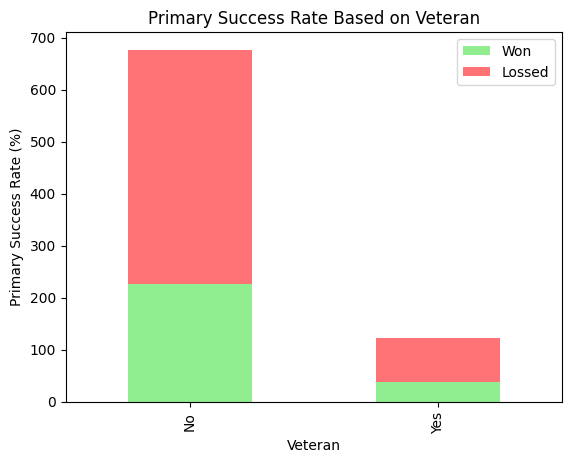

Primary Status,Advanced,Lost
Veteran?,,
No,227,450
Yes,38,85


In [ ]:
personal_characteristics_success_rate = dems.groupby(['Veteran?'])['Primary Status'].value_counts().unstack().fillna(0)
personal_characteristics_success_rate.plot(kind = 'bar', stacked = True, color = ['#90EE90', '#FF7276'])

plt.xlabel('Veteran')
plt.ylabel('Primary Success Rate (%)')
plt.title('Primary Success Rate Based on Veteran')
plt.legend(['Won', 'Lossed'])
plt.show()

personal_characteristics_success_rate

In [ ]:
print('Percent of success within candidates who are Veterans: ', (38/85)*100) 
print('Percent of success within candidates who are not Veterans: ', (227/450)*100) 
print('Difference between percentages: ', (227/450)*100 - (38/85)*100)

Percent of success within candidates who are Veterans:  44.70588235294118
Percent of success within candidates who are not Veterans:  50.44444444444445
Difference between percentages:  5.738562091503269


**Take Aways:** The is a 5.738 % difference in success between veteran and non veteran candidates. Although this isn't a big difference, there is potential for veteran status to impact primary success. We will need to do testing to see if this is the case.

#### Visualizations for Hypothesis 3

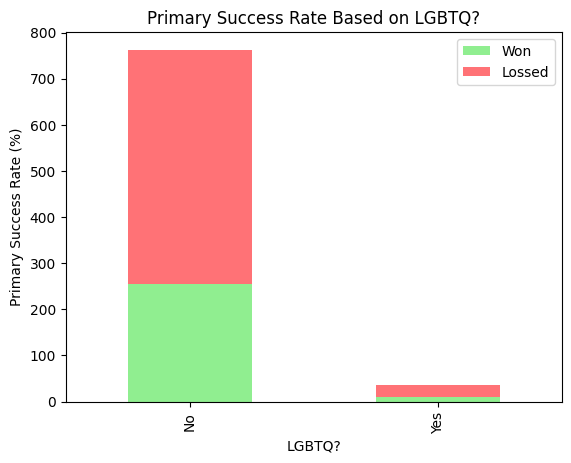

Primary Status,Advanced,Lost
LGBTQ?,,
No,254,509
Yes,11,26


In [ ]:
personal_characteristics_success_rate = dems.groupby(['LGBTQ?'])['Primary Status'].value_counts().unstack().fillna(0)
personal_characteristics_success_rate.plot(kind = 'bar', stacked = True, color = ['#90EE90', '#FF7276'])

plt.xlabel('LGBTQ?')
plt.ylabel('Primary Success Rate (%)')
plt.title('Primary Success Rate Based on LGBTQ?')
plt.legend(['Won', 'Lossed'])
plt.show()

personal_characteristics_success_rate

In [ ]:
print('Percent of success within candidates who are part of the LGBTQ community: ', (11/26)*100) 
print('Percent of success within candidates who are not part of the LGBTQ community: ', (254/509)*100)
print('Difference between percentages:', (254/509)*100 - (11/26)*100)

Percent of success within candidates who are part of the LGBTQ community:  42.30769230769231
Percent of success within candidates who are not part of the LGBTQ community:  49.90176817288802
Difference between percentages: 7.5940758651957125


**Take Aways:** The is a 7.594 % difference in success between candidates who identify as LGBTQ. Although this isn't a big difference, there is potential for LGBTQ status to impact primary success. We will need to do testing to see if this is the case.

#### Visualization for Hypothesis 4

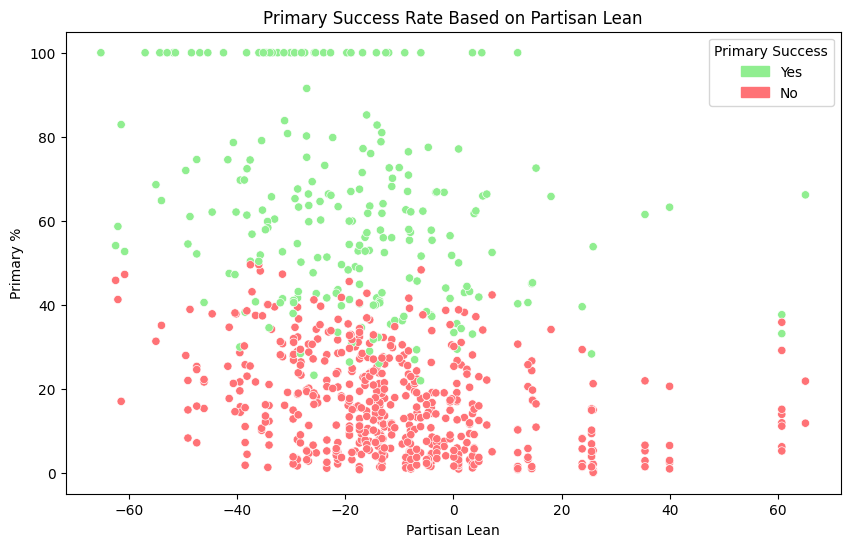

In [ ]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='Partisan Lean', y='Primary %', hue='Won Primary', data=dems, palette=['#FF7276', '#90EE90'])

plt.title('Primary Success Rate Based on Partisan Lean')
plt.xlabel('Partisan Lean')
plt.ylabel('Primary %')

legend_labels = ['Yes', 'No']
legend_patches = [Patch(color=color, label=label) for color, label in zip(['#90EE90', '#FF7276'], legend_labels)]

plt.legend(handles=legend_patches, title='Primary Success', loc='upper right')
plt.show()

In [ ]:
won_df = dems['Won Primary'].map({'Yes': 1, 'No': 0})
print('Correlation between Partisan Lean and Primary %: ', dems['Partisan Lean'].corr(dems['Primary %']))
print('Correlation between Partisan Lean and Primary Success: ', dems['Partisan Lean'].corr(won_df))

Correlation between Partisan Lean and Primary %:  -0.32064837995428497
Correlation between Partisan Lean and Primary Success:  -0.1912107490213876


**Take Aways:** The Pearson's correlation between Partisan Lean and Primary % of -0.32 indicates that as Partisan Lean increases, the primary % tends to decrease. This is interesting because this shows that as the district or state becomes more Democratic-leaning, the percentage of the primary vote received tends to decrease. This shows a negative association between partisan lean and primary %. However, it is important to know this is not a strong correlation; this is a medium correlation, as it is greater than 0.3  but less than 0.7 away from 0.

The Pearson's correlation between Partisan Lean and Primary Success suggests that on average as the district or state becomes more democratic leaning, the likelihood of winning tends to decrease. This might suggest that winning primaries in a more democratic-leaning area is a bit more challenging. This shows a negative association between partisan lean and primary success. However this is a weak correlation as it is less than 0.29 away from 0.

## EDA for Question 1: Part 2

#### Visualization for Hypothesis 5

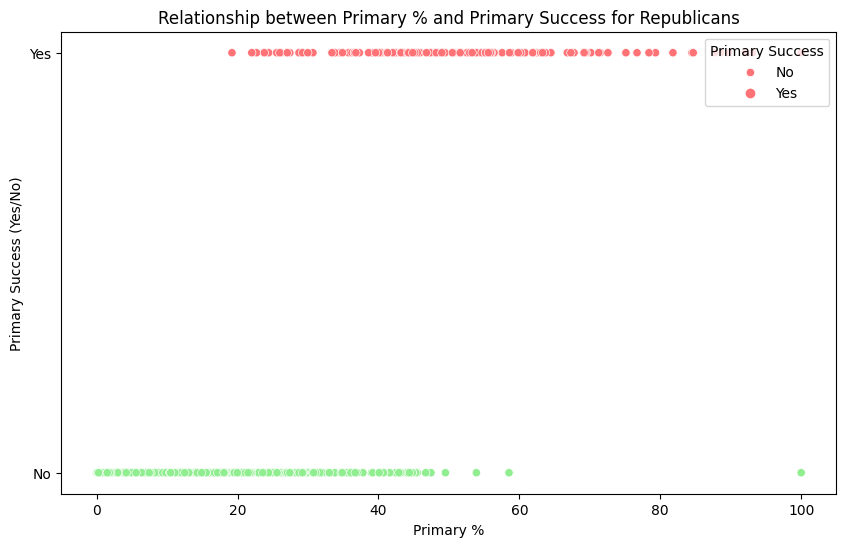

In [ ]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='Primary %', y='Won Primary', data=rep, hue='Won Primary', palette=['#FF7276', '#90EE90'])

plt.title('Relationship between Primary % and Primary Success for Republicans')
plt.xlabel('Primary %')
plt.ylabel('Primary Success (Yes/No)')

plt.legend(title='Primary Success', loc='upper right', labels=['No', 'Yes'])
plt.show()

In [ ]:
won = rep['Won Primary'].map({'Yes': 1, 'No': 0})
print('Correlation between Primary % and Primary Success ', rep['Primary %'].corr(won))

Correlation between Primary % and Primary Success  0.8132312710156182


**Take Aways:** The correlation between Primary % and Primary success is 0.813 which is considered a strong correlation. This suggest that as the primary % increases, so does the likelihood of primary success.

#### Visualization for Hypothesis 6

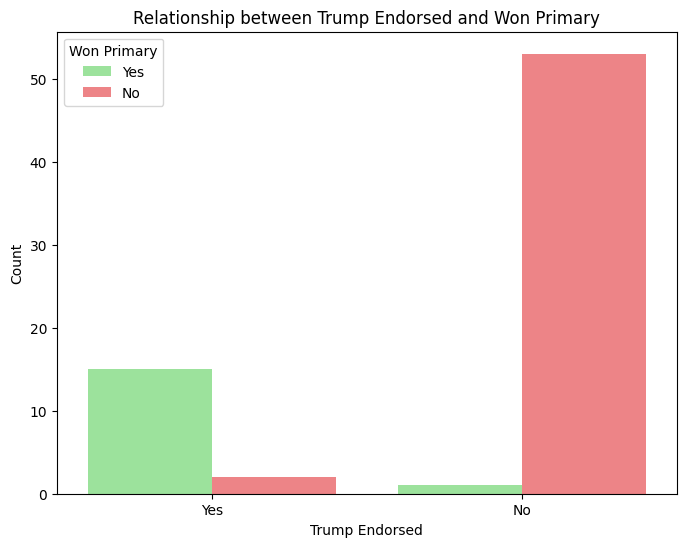

Won Primary,No,Yes
Trump Endorsed?,,
No,53,1
Yes,2,15


In [ ]:
reps_individuals = rep[['Trump Endorsed?', 'Won Primary']]
plt.figure(figsize=(8, 6))
sns.countplot(x='Trump Endorsed?', hue='Won Primary', data=reps_individuals, palette=['#90EE90', '#FF7276'])
plt.title('Relationship between Trump Endorsed and Won Primary')
plt.xlabel('Trump Endorsed')
plt.ylabel('Count')
plt.show()

pd.crosstab(reps_individuals['Trump Endorsed?'], reps_individuals['Won Primary'])

In [ ]:
print('Percent of success within Trump endorsed candidates: ', (15/17)*100)
print('Percent of success within non Trump endorsed candidates:', (1/53)*100)
print('Difference in percentages: ', ((15/17)*100) - ((1/53)*100))

Percent of success within Trump endorsed candidates:  88.23529411764706
Percent of success within non Trump endorsed candidates: 1.8867924528301887
Difference in percentages:  86.34850166481687


**Take Aways:** The is a 86.34 % difference in success between candidates who are endorsed by Trump. This is a big difference which means it is very likely that being endorsed by Trump can positivly impact a candidates success rates in the primaries. We will need to do testing to see if this is the case.

### Testing
#### **1. Democratic candidates who self-fund their campaigns have a higher primary success rate.**

**Null Hypothesis:** There is no association between the self-funding status of Democratic candidates and their primary success rate.
**Alternative Hypothesis:** There is an association between the self-funding status of Democratic candidates and their primary success rate. 

In [ ]:
#Chi-Squared Test
df_self_funded = dems[['Self-Funder?', 'Won Primary']]
tbl_self_funded = pd.crosstab(df_self_funded['Self-Funder?'], df_self_funded['Won Primary'])
chi2_self_funded, p_self_funded, dof_self_funded, expected_self_funded = chi2_contingency(tbl_self_funded)
print('p-value: ', p_self_funded)

p-value:  0.8577025325396138


**Interpretation:** The Pearson Correlation Test resulted in a pvalue of 0.8577025325396138. at the 5% significance level we have sufficient evidence to conclude that there is a significant association between being self-funded for Democratic candidates and their percentage of primary vote.

#### 2. Democratic candidates with a more favorable partisan lean have a higher primary success rate.
**Null Hypothesis:**  There is no association between the partisan lean of Democratic candidates and their percentage of primary votes.
**Alternative Hypothesis:**  There is an association between the partisan lean of Democratic candidates and their percentage of primary votes.


In [ ]:
#Pearson Correlation Test
partisan_lean_primary_success = dems[['Partisan Lean', 'Primary %']]
partisan_lean_primary_success = partisan_lean_primary_success.dropna()
partisan_lean = partisan_lean_primary_success['Partisan Lean']
primary_success = partisan_lean_primary_success['Primary %']
corr, p = pearsonr(partisan_lean, primary_success)
print('p-value: ', p)

p-value:  1.3067093778180848e-20


**Interpretation:** The Pearson Correlation Test resulted in a pvalue of 1.306e-20. at the 5% significance level we have sufficient evidence to conclude that there is a significant association between the partisan lean of Democratic candidates and their percentage of primary vote.

#### 3. Veteran status of Democratic candidates impacts the success in winning primaries.

**Null Hypothesis:** There is no association between being a veteran and and their primary success rate.
**Alternative Hypothesis:**  There is an association between being a veteran and and their primary success rate.

In [ ]:
#Chi-Squared Test
df_vet = dems[['Veteran?', 'Won Primary']]
tbl_vet = pd.crosstab(df_vet['Veteran?'],  df_vet['Won Primary'])
chi2_vet, p_vet, dof_vet, expected_vet = chi2_contingency(tbl_vet)
print('p-value: ', p_vet)

p-value:  0.9902576837437134


**Interpretation:** The Chi Square Test resulted in a pvalue of 0.99, at the 5% significance level, we have insufficient evidence to claim that there is an association between the veteran status of the candidate and their primary success rate. 

#### 4.  LGBTQ status of Democratic candidates impacts the success in winning primaries.
**Null Hypothesis:** There is no association between being part of the LGBTQ community and their primary success rate.
**Alternative Hypothesis:**  There is an association between being part of the LGBTQ community and their primary success rate.

In [ ]:
#Chi-Squared Test
df_lgbtq = dems[['LGBTQ?', 'Won Primary']]
tbl_lgbtq = pd.crosstab(df_lgbtq['LGBTQ?'],  df_lgbtq['Won Primary'])
chi2_lgbtq, p_lgbtq, dof_lgbtq, expected_lgbtq = chi2_contingency(tbl_lgbtq)
print('p-value: ', p_lgbtq)

p-value:  1.0


**Interpretation:** The Chi Square Test resulted in a pvalue of 1.0, at the 5% significance level, we have insufficient evidence to claim that there is an association between the LGBTQ status of the candidate and their primary success rate. 

#### 5.  Primary %  of Republican candidates impacts their primary success rate.

**Null Hypothesis:** There is no association between primary % and their primary success rate.
**Alternative Hypothesis:** There is an association between primary % and their primary success rate.

In [ ]:
#T-Test
from scipy.stats import ttest_ind

primary_success_yes = rep[rep['Won Primary'] == 'Yes']['Primary %']
primary_success_no = rep[rep['Won Primary'] == 'No']['Primary %']

primary_success_yes = primary_success_yes.dropna()
primary_success_no = primary_success_no.dropna()

statistic, p_value = ttest_ind(primary_success_yes, primary_success_no, equal_var=False)

print(f"Independent Samples t-Test Statistic: {statistic}")
print(f"P-value: {p_value}")

Independent Samples t-Test Statistic: 30.877996186410385
P-value: 4.086371285865596e-95


**Interpretation:** The T-test resulted in a pvalue of 4.086e-95. At the 5% significance level, we have sufficient evidence to conclude that there is a significant association between the Primary % of the candidate and their primary success rate.

#### 6. Republican candidates who are endorsed by Trump have a higher primary success rate.

**Null Hypothesis:** There is no association between being endorsed by Trump and winning primaries.
**Alternative Hypothesis:** There is an association between being endorsed by Trump and winning primaries.

In [ ]:
# Chi-Squared Test
reps_individuals = rep[['Trump Endorsed?', 'Won Primary']]
individual_table = pd.crosstab(reps_individuals['Trump Endorsed?'], reps_individuals['Won Primary'], rownames=['Trump Endorsed?'], colnames=['Won Primary'])
chisquared_reps_individuals, p_reps_individual, dof_reps_individual, expected_reps_individual = chi2_contingency(individual_table)
print('p-value:', p_reps_individual)

p-value: 1.2342398189312918e-12


**Interpretation:** The Chi Square Test resulted in a pvalue of 1.234e-12. At the 5% significance level, we have sufficient evidence to conclude that there is a significant association between the candidate being endorsed by Trump and their primary success rate.

### P-Value Correction - Bonferroni

In [ ]:
alpha = 0.05
p_values = [0.8577025325396138, 1.3067093778180848e-20, 0.9902576837437134, 1.0, 4.086371285865596e-95,  1.2342398189312918e-12]
num_p_values = len(p_values)

# Taken from Lab 1, Basics of Testing
def Bonferroni(p_vals, a, num_p):
    decisions = p_vals < (a / np.asarray(num_p))
    return decisions

Bonferroni(p_values, alpha, num_p_values)

array([False,  True, False, False,  True,  True])

In [ ]:
# Inspiration also taken from Lab 1, Basics of Testing


def b_y_correction(alpha, p_vals):
    p_sorted = np.sort(p_values)
    n = len(p_sorted)
    indices = np.arange(1, n + 1)
    top = alpha * indices
    bottom = np.log(n) + 0.57721 + 1 / 2 * n
    y = top / bottom
    accept = p_sorted[p_sorted <= y]
    decisions = p_values <= max(accept)
    return decisions

b_y_correction(0.05, p_values)

array([False,  True, False, False,  True,  True])

**True** = reject null
**False** = fail to reject the null

## Research Question 2: 
### Causal Inference
    What is the causal impact of high-profile political endorsements on the primary election outcomes of candidates?

### EDA for Question 2: Part 1

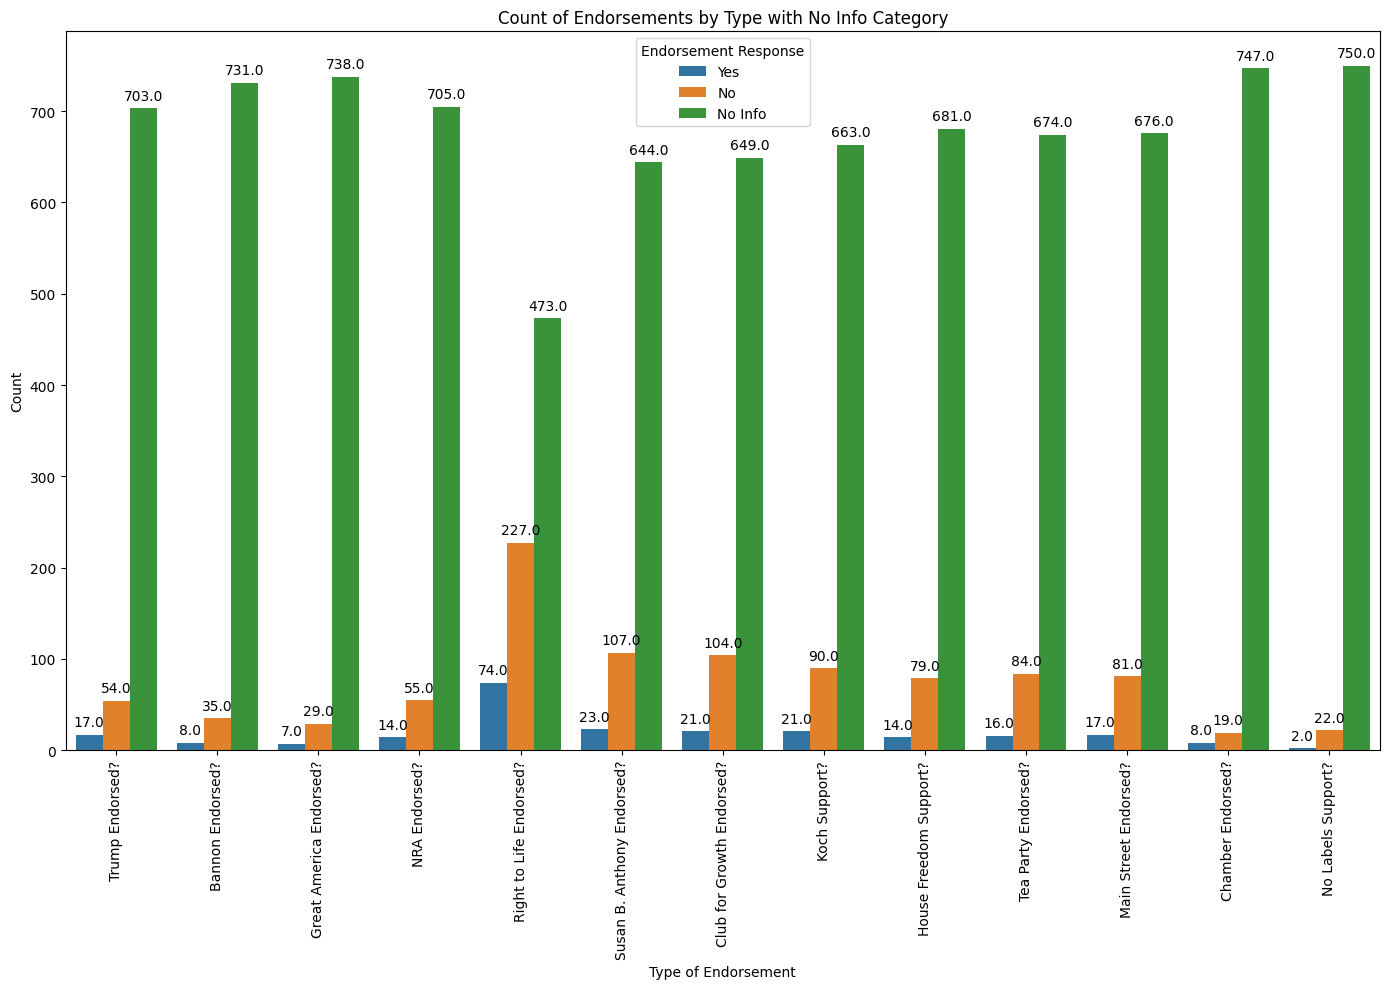

In [ ]:
# Prepare a dataframe for endorsements
endorsements = ['Trump Endorsed?', 'Bannon Endorsed?', 'Great America Endorsed?', 
                'NRA Endorsed?', 'Right to Life Endorsed?', 'Susan B. Anthony Endorsed?', 
                'Club for Growth Endorsed?', 'Koch Support?', 'House Freedom Support?', 
                'Tea Party Endorsed?', 'Main Street Endorsed?', 'Chamber Endorsed?', 
                'No Labels Support?']

# Initialize a list to hold count data
endorsement_counts = []

# Count the occurrences of 'Yes', 'No', and 'No Info' for each endorsement type
for endorsement in endorsements:
    yes_count = rep[endorsement].value_counts().get('Yes', 0)
    no_count = rep[endorsement].value_counts().get('No', 0)
    no_info_count = rep[endorsement].isnull().sum()  # Count 'No Info' as null entries
    endorsement_counts.append({'Endorsement': endorsement, 'Count': yes_count, 'Response': 'Yes'})
    endorsement_counts.append({'Endorsement': endorsement, 'Count': no_count, 'Response': 'No'})
    endorsement_counts.append({'Endorsement': endorsement, 'Count': no_info_count, 'Response': 'No Info'})

# Convert list to dataframe
endorsement_df = pd.DataFrame(endorsement_counts)

# Plotting all endorsements with count labels
plt.figure(figsize=(14, 10))
barplot = sns.barplot(x='Endorsement', y='Count', hue='Response', data=endorsement_df)
plt.xticks(rotation=90)
plt.title('Count of Endorsements by Type with No Info Category')
plt.xlabel('Type of Endorsement')
plt.ylabel('Count')

# Adding count labels on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.legend(title='Endorsement Response')
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

**Count of Endorsements by Type with No Info Category:** This visualization offers a detailed breakdown of the number of candidates who have received specific high-profile political endorsements, those who have not, and those for whom there is no information. Each bar represents one type of endorsement, such as those from Trump, Bannon, and Great America, which are central to the treatment variable in the causal study.

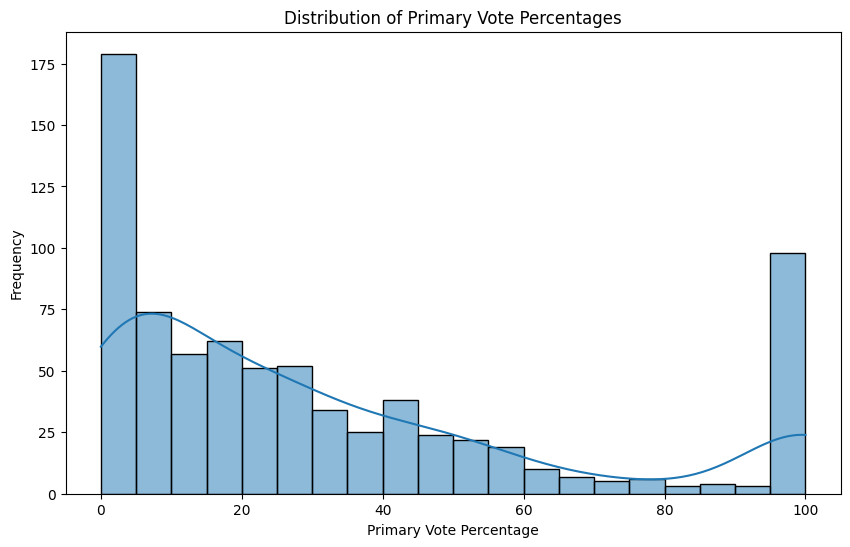

In [ ]:
# Quantitative Variable 1: Primary %
plt.figure(figsize=(10, 6))
sns.histplot(rep['Primary %'].dropna(), bins=20, kde=True)
plt.title('Distribution of Primary Vote Percentages')
plt.xlabel('Primary Vote Percentage')
plt.ylabel('Frequency')
plt.show()

**Distribution of Primary Vote Percentages:** The histogram displays the frequency distribution of the primary vote percentages that candidates received. It shows how many candidates fall within various percentage ranges, giving an overview of how competitive the primaries were and indicating the proportion of votes candidates attracted.

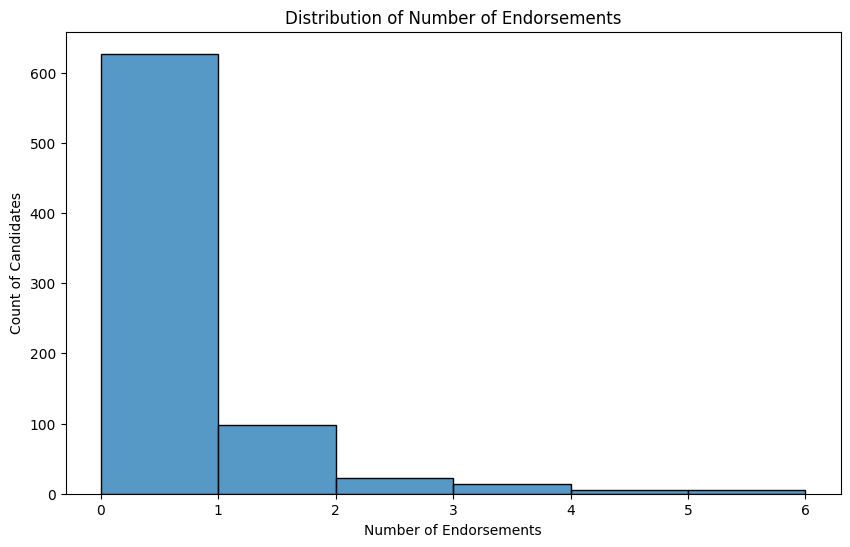

In [ ]:
# Quantitative Variable 2: Number of Endorsements
# Creating a new column for the count of 'Yes' endorsements
rep['Num_Endorsements'] = rep[endorsements].apply(lambda row: row.value_counts().get('Yes', 0), axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(rep['Num_Endorsements'], bins=range(rep['Num_Endorsements'].max()+1), kde=False)
plt.title('Distribution of Number of Endorsements')
plt.xlabel('Number of Endorsements')
plt.ylabel('Count of Candidates')
plt.show()

**Distribution of Number of Endorsements:** This histogram illustrates the number of endorsements each candidate received. A candidate with multiple endorsements may be perceived as having more support, which could influence their primary election outcomes.

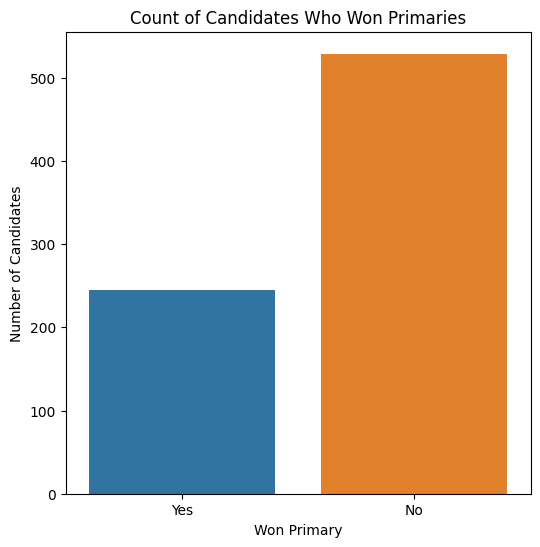

In [ ]:
# Categorical Variable 1: Won Primary
plt.figure(figsize=(6, 6))
sns.countplot(x='Won Primary', data=rep)
plt.title('Count of Candidates Who Won Primaries')
plt.xlabel('Won Primary')
plt.ylabel('Number of Candidates')
plt.show()

**Count of Candidates Who Won Primaries:** The bar chart shows the number of candidates who won their primaries versus those who did not. This clear binary outcome is directly linked to one of the key outcome variables in the causal inference analysis.

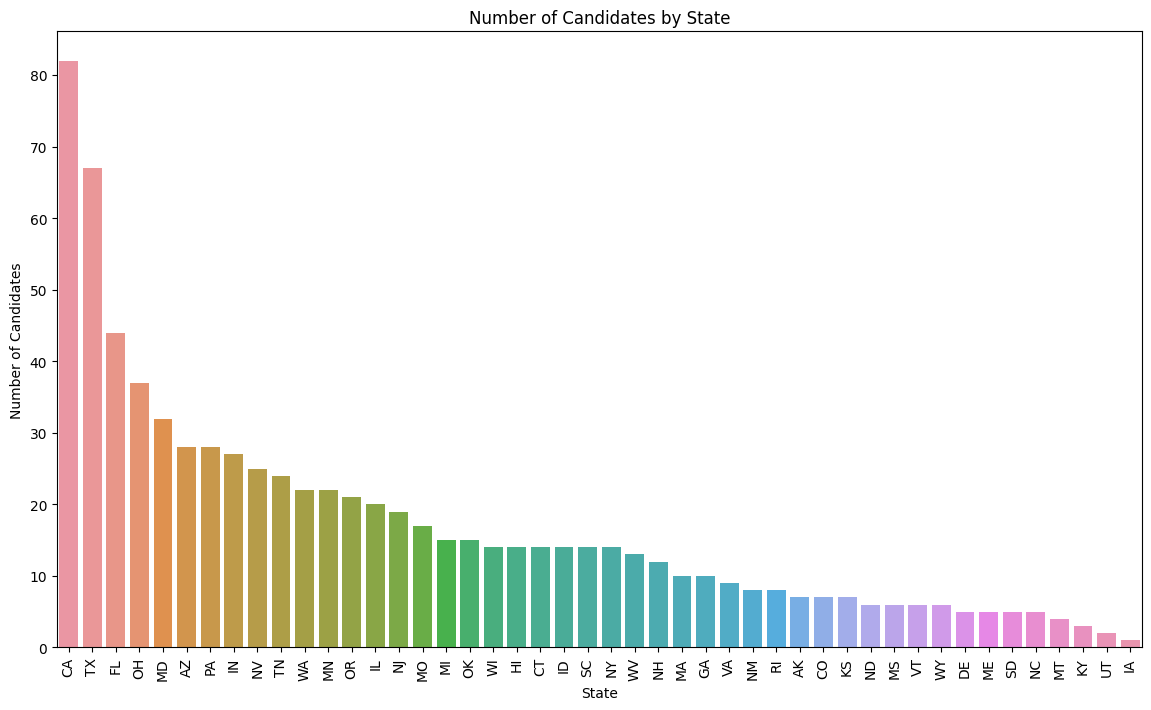

In [ ]:
# Categorical Variable 2: State
plt.figure(figsize=(14, 8))
sns.countplot(x='State', data=rep, order = rep['State'].value_counts().index)
plt.title('Number of Candidates by State')
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Number of Candidates')
plt.show()

**Number of Candidates by State:** This bar chart ranks states by the number of candidates who ran in the Republican primaries. The state is a potential confounder in the causal relationship between endorsements and election outcomes, as political dynamics can vary significantly by region.

### Relevance to the Research Question
These visualizations collectively serve to inform the causal inference analysis by identifying and describing both the treatment (endorsements) and outcomes ('Primary %' and 'Won Primary'). They reveal the distribution and prevalence of endorsements, the competitiveness of the primaries, and the success rates of candidates, all of which are pivotal in understanding the electoral landscape. The variation in the number of endorsements and the differences in primary outcomes by state are particularly relevant for propensity score matching. By comparing endorsed candidates to similar non-endorsed candidates, controlling for confounders like state and number of endorsements, researchers can attempt to isolate the effect of high-profile endorsements on election outcomes. This analytical approach is designed to approximate a randomized control trial, enhancing the credibility of causal claims about the influence of endorsements.

### EDA for Question 2: Part 2

In [ ]:
#Not a single row has all values present 
dems.dropna()

#Find the rows which have primary winners 
dem_prim_win = dems[dems['Won Primary'] == 'Yes']

#Proportion of Democrats who won their Primaries
len (dem_prim_win) / len(dems)

#What is the proportion of Obama alum's who also won their primaries? Did they advance? 
dem_advanced = dems[dems['Primary Status'] == 'Advanced']
dem_advanced = dem_advanced[dem_advanced['Obama Alum?'] == 'Yes']
dem_advanced

#Non-Governors Dem
dems[dems["Office Type"] != "Governor"].head(3)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
6,Lizzetta Hill McConnell,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,Lost,None,None,-30.680000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Robert Kennedy Jr.,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,Advanced,None,On the Ballot,-30.680000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Audri Scott Williams,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Lost,None,None,-33.080002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


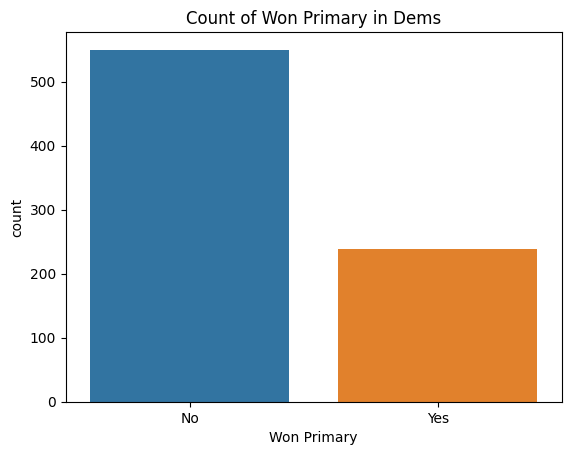

In [ ]:
sns.countplot(data=dems, x="Won Primary")
plt.title('Count of Won Primary in Dems')
plt.show()

## Causal DAG

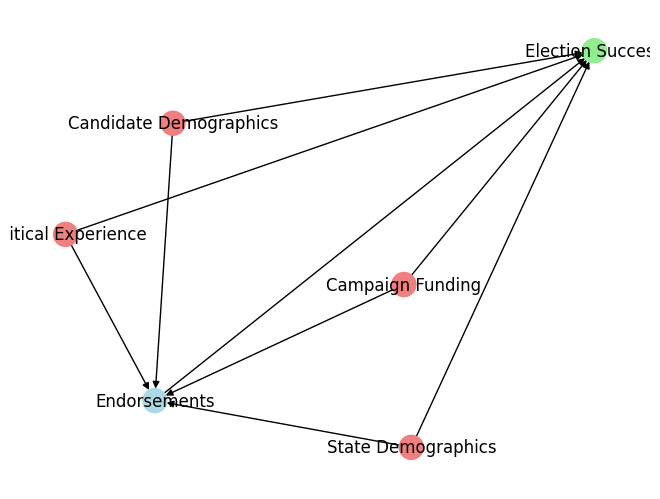

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
dag = nx.DiGraph()

# Add nodes representing variables
dag.add_node("Endorsements", color='lightblue')
dag.add_node("Election Success", color='lightgreen')
dag.add_node("Candidate Demographics", color='lightcoral')
dag.add_node("Political Experience", color='lightcoral')
dag.add_node("Campaign Funding", color='lightcoral')
dag.add_node("State Demographics", color='lightcoral')

# Add edges representing causal relationships
dag.add_edge("Candidate Demographics", "Endorsements")
dag.add_edge("Political Experience", "Endorsements")
dag.add_edge("Campaign Funding", "Endorsements")
dag.add_edge("State Demographics", "Endorsements")
dag.add_edge("Candidate Demographics", "Election Success")
dag.add_edge("Political Experience", "Election Success")
dag.add_edge("Campaign Funding", "Election Success")
dag.add_edge("State Demographics", "Election Success")
dag.add_edge("Endorsements", "Election Success")

# Draw the DAG
colors = [dag.nodes[n]['color'] for n in dag.nodes]
pos = nx.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, arrows=True, node_color=colors)
plt.show()


### Causal inference analysis on rep_candidates.csv

In [ ]:

# Combine all endorsements into a single treatment variable
endorsements = ['Trump Endorsed?', 'Bannon Endorsed?', 'Great America Endorsed?', 
                'NRA Endorsed?', 'Right to Life Endorsed?', 'Susan B. Anthony Endorsed?', 
                'Club for Growth Endorsed?', 'Koch Support?', 'House Freedom Support?', 
                'Tea Party Endorsed?', 'Main Street Endorsed?', 'Chamber Endorsed?', 
                'No Labels Support?']
rep['Any Endorsement'] = rep[endorsements].apply(lambda row: any(row == 'Yes'), axis=1).astype(int)

# Encode 'Won Primary' as a binary outcome variable
rep['Won Primary'] = rep['Primary Status'].map({'Advanced': 1, 'Lost': 0}).fillna(0)

X = rep[['Any Endorsement']]  # Treatment variable
y = rep['Won Primary']  # Outcome variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_scaled, y)
rep['Propensity Score'] = logistic_regression.predict_proba(X_scaled)[:, 1]

# Prepare treated and control groups
treated = rep[rep['Any Endorsement'] == 1]
control = rep[rep['Any Endorsement'] == 0]

# Function to perform caliper matching and calculate ATT
def calculate_att(caliper_width):
    matched_pairs = []
    control_pool = control.copy()  # Reset control pool for each caliper width

    for index, treat_row in treated.iterrows():
        potential_matches = control_pool[np.abs(control_pool['Propensity Score'] - treat_row['Propensity Score']) <= caliper_width]
        if not potential_matches.empty:
            closest_match = potential_matches.iloc[(potential_matches['Propensity Score'] - treat_row['Propensity Score']).abs().argsort()[:1]]
            matched_pairs.append((index, closest_match.index[0]))
            control_pool = control_pool.drop(closest_match.index)

    if matched_pairs:
        matched_treated = rep.loc[[mp[0] for mp in matched_pairs]]
        matched_control = rep.loc[[mp[1] for mp in matched_pairs]]
        att = matched_treated['Won Primary'].mean() - matched_control['Won Primary'].mean()
        return att
    else:
        return np.nan

# Test different caliper widths
caliper_results = {}
for caliper in np.arange(0.01, 0.51, 0.01):  # Increment caliper width from 0.01 to 0.5
    att = calculate_att(caliper)
    caliper_results[caliper] = att

# Display the results
for caliper, att in caliper_results.items():
    print(f"Caliper: {caliper}, ATT: {att}")

Caliper: 0.01, ATT: nan
Caliper: 0.02, ATT: nan
Caliper: 0.03, ATT: nan
Caliper: 0.04, ATT: nan
Caliper: 0.05, ATT: nan
Caliper: 0.060000000000000005, ATT: nan
Caliper: 0.06999999999999999, ATT: nan
Caliper: 0.08, ATT: nan
Caliper: 0.09, ATT: nan
Caliper: 0.09999999999999999, ATT: nan
Caliper: 0.11, ATT: nan
Caliper: 0.12, ATT: nan
Caliper: 0.13, ATT: nan
Caliper: 0.14, ATT: nan
Caliper: 0.15000000000000002, ATT: nan
Caliper: 0.16, ATT: nan
Caliper: 0.17, ATT: nan
Caliper: 0.18000000000000002, ATT: nan
Caliper: 0.19, ATT: nan
Caliper: 0.2, ATT: nan
Caliper: 0.21000000000000002, ATT: nan
Caliper: 0.22, ATT: nan
Caliper: 0.23, ATT: nan
Caliper: 0.24000000000000002, ATT: nan
Caliper: 0.25, ATT: nan
Caliper: 0.26, ATT: 0.23809523809523814
Caliper: 0.27, ATT: 0.23809523809523814
Caliper: 0.28, ATT: 0.23809523809523814
Caliper: 0.29000000000000004, ATT: 0.23809523809523814
Caliper: 0.3, ATT: 0.23809523809523814
Caliper: 0.31, ATT: 0.23809523809523814
Caliper: 0.32, ATT: 0.23809523809523814
C

In [ ]:
# Setting the best caliper width
best_caliper = 0.26

# Preparing the treated and control groups
treated = rep[rep['Any Endorsement'] == 1]
control = rep[rep['Any Endorsement'] == 0]

# Performing caliper matching at the best caliper width
matched_pairs = []

for index, treat_row in treated.iterrows():
    potential_matches = control[np.abs(control['Propensity Score'] - treat_row['Propensity Score']) <= best_caliper]
    if not potential_matches.empty:
        closest_match = potential_matches.iloc[(potential_matches['Propensity Score'] - treat_row['Propensity Score']).abs().argsort()[:1]]
        matched_pairs.append((index, closest_match.index[0]))
        # Removing the matched control unit to avoid duplicate matches
        control = control.drop(closest_match.index)

# Calculate the ATT
matched_treated = rep.loc[[mp[0] for mp in matched_pairs]]
matched_control = rep.loc[[mp[1] for mp in matched_pairs]]

att = matched_treated['Won Primary'].mean() - matched_control['Won Primary'].mean()

# Output the ATT
print(f"Average Treatment Effect on the Treated (ATT) at Caliper {best_caliper}: {att}")

Average Treatment Effect on the Treated (ATT) at Caliper 0.26: 0.23809523809523814


**Introduction:** This research focuses on assessing the causal effect of receiving high-profile political endorsements on the likelihood of winning primary elections. We employed propensity score matching to estimate the Average Treatment Effect (ATT) of endorsements.

**Methodology:** The dataset comprised candidates from primary elections, with information on whether they received endorsements from various high-profile figures and organizations. The treatment variable was a binary indicator representing any high-profile endorsement received. The primary outcome of interest was the binary variable 'Won Primary'. We utilized caliper matching, a propensity score matching technique, to compare endorsed candidates (treatment group) with non-endorsed candidates (control group).

**Findings:** Failure of Matching at Lower Caliper Widths: When caliper widths were increased from 0.01 to 0.25, the ATT results consistently returned nan. This indicates that at these narrower widths, we could not find a sufficient number of matches. It is likely due to the challenge of finding adequately similar candidates between the treatment and control groups within the restricted caliper width.

Successful Matching at Caliper Width 0.26 and Above: Starting from a caliper width of 0.26, effective matches were found, resulting in a stable ATT value of approximately 0.2381. This suggests that at and above this caliper width, a sufficient number of matches were identified, and an average treatment effect was successfully computed.

**Stability of ATT:** The ATT value remained stable at about 0.2381 from a caliper width of 0.26 onwards. This stability indicates that the quality of matches at these widths is acceptable. The ATT of approximately 0.2381 implies that candidates who received any high-profile endorsement had, on average, a 23.81% higher probability of winning their primary elections compared to similar candidates who did not receive such endorsements.

**Conclusion:** The findings suggest a significant impact of high-profile political endorsements on the success of candidates in primary elections. The stable ATT value across a range of caliper widths indicates a robust effect of endorsements. However, the results should be interpreted considering potential limitations, such as the data's representativeness and the possibility of unobserved confounding factors.

### The statistical significance of the Average Treatment Effect (ATE)

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Assuming 'matched_treated' and 'matched_control' are DataFrames containing your matched treatment and control groups

# Count of successes (candidates who won the primary) in both groups
count_treated_won = matched_treated['Won Primary'].sum()
count_control_won = matched_control['Won Primary'].sum()

# Number of observations in both groups
nobs_treated = matched_treated['Won Primary'].count()
nobs_control = matched_control['Won Primary'].count()

# Perform the Z-test
stat, p_value = proportions_ztest([count_treated_won, count_control_won], [nobs_treated, nobs_control])

# Print the p-value
print(f"P-value: {p_value}")

P-value: 3.503374651950894e-05


**Statistical Significance:** The results provide strong statistical evidence supporting the hypothesis that high-profile political endorsements significantly increase a candidate's chances of winning primary elections.
**Effect Size:** The effect size (ATT) of about 23.81% is substantial, underscoring the practical importance of endorsements in election strategies.

### Causal inference analysis test on  dem_candidates.csv

In [ ]:
# Combine all endorsements into a single treatment variable for the Democratic dataset
endorsements_dem = ['Emily Endorsed?', 'Guns Sense Candidate?', 'Biden Endorsed?', 
                    'Sanders Endorsed?', 'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 
                    'PCCC Endorsed?', 'Indivisible Endorsed?', 'WFP Endorsed?', 
                    'VoteVets Endorsed?', 'No Labels Support?']
dems['Any Endorsement'] = dems[endorsements_dem].apply(lambda row: any(row == 'Yes'), axis=1).astype(int)

# Encode 'Won Primary' as a binary outcome variable
dems['Won Primary'] = dems['Primary Status'].map({'Advanced': 1, 'Lost': 0}).fillna(0)

# Estimating propensity scores for the Democratic dataset
X_dem = dems[['Any Endorsement']]
y_dem = dems['Won Primary']

scaler_dem = StandardScaler()
X_dem_scaled = scaler_dem.fit_transform(X_dem)

logistic_regression_dem = LogisticRegression()
logistic_regression_dem.fit(X_dem_scaled, y_dem)
dems['Propensity Score'] = logistic_regression_dem.predict_proba(X_dem_scaled)[:, 1]

In [ ]:
# Function to perform caliper matching and calculate ATT for the Democratic dataset
def calculate_att_dem(caliper_width, dataset):
    treated = dataset[dataset['Any Endorsement'] == 1]
    control = dataset[dataset['Any Endorsement'] == 0]
    matched_pairs = []
    control_pool = control.copy()  # Reset control pool for each caliper width

    for index, treat_row in treated.iterrows():
        potential_matches = control_pool[np.abs(control_pool['Propensity Score'] - treat_row['Propensity Score']) <= caliper_width]
        if not potential_matches.empty:
            closest_match = potential_matches.iloc[(potential_matches['Propensity Score'] - treat_row['Propensity Score']).abs().argsort()[:1]]
            matched_pairs.append((index, closest_match.index[0]))
            control_pool = control_pool.drop(closest_match.index)

    if matched_pairs:
        matched_treated = dataset.loc[[mp[0] for mp in matched_pairs]]
        matched_control = dataset.loc[[mp[1] for mp in matched_pairs]]
        att = matched_treated['Won Primary'].mean() - matched_control['Won Primary'].mean()
        return att
    else:
        return np.nan

# Test different caliper widths for the Democratic dataset
caliper_results_dem = {}
for caliper in np.arange(0.01, 0.51, 0.01):  # Increment caliper width from 0.01 to 0.5
    att = calculate_att_dem(caliper, dems)
    caliper_results_dem[caliper] = att

# Display the results for the Democratic dataset
for caliper, att in caliper_results_dem.items():
    print(f"Caliper (DEM): {caliper}, ATT: {att}")

Caliper (DEM): 0.01, ATT: nan
Caliper (DEM): 0.02, ATT: nan
Caliper (DEM): 0.03, ATT: nan
Caliper (DEM): 0.04, ATT: nan
Caliper (DEM): 0.05, ATT: nan
Caliper (DEM): 0.060000000000000005, ATT: nan
Caliper (DEM): 0.06999999999999999, ATT: nan
Caliper (DEM): 0.08, ATT: nan
Caliper (DEM): 0.09, ATT: nan
Caliper (DEM): 0.09999999999999999, ATT: nan
Caliper (DEM): 0.11, ATT: nan
Caliper (DEM): 0.12, ATT: nan
Caliper (DEM): 0.13, ATT: nan
Caliper (DEM): 0.14, ATT: nan
Caliper (DEM): 0.15000000000000002, ATT: nan
Caliper (DEM): 0.16, ATT: nan
Caliper (DEM): 0.17, ATT: nan
Caliper (DEM): 0.18000000000000002, ATT: nan
Caliper (DEM): 0.19, ATT: nan
Caliper (DEM): 0.2, ATT: nan
Caliper (DEM): 0.21000000000000002, ATT: nan
Caliper (DEM): 0.22, ATT: nan
Caliper (DEM): 0.23, ATT: nan
Caliper (DEM): 0.24000000000000002, ATT: nan
Caliper (DEM): 0.25, ATT: nan
Caliper (DEM): 0.26, ATT: nan
Caliper (DEM): 0.27, ATT: nan
Caliper (DEM): 0.28, ATT: 0.2923076923076923
Caliper (DEM): 0.29000000000000004, ATT:

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Count of successes (candidates who won the primary) in both groups
count_treated_won_dem = matched_treated['Won Primary'].sum()
count_control_won_dem = matched_control['Won Primary'].sum()

# Number of observations in both groups
nobs_treated_dem = matched_treated['Won Primary'].count()
nobs_control_dem = matched_control['Won Primary'].count()

# Perform the Z-test
stat_dem, p_value_dem = proportions_ztest([count_treated_won_dem, count_control_won_dem], [nobs_treated_dem, nobs_control_dem])

# Print the p-value
print(f"P-value (DEM): {p_value_dem}")

P-value (DEM): 3.503374651950894e-05


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b6c7cb0d-5b40-4f8d-9e47-638794925e08' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>